In [5]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv("../train_dataset_scaled_robust_transformation.csv")

target = "smoking"

X = df.drop(columns=[target])
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# OPTUNA OBJECTIVE FUNCTION
def objective(trial):

    C = trial.suggest_float("C", 1e-3, 10, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 500)

    model = LogisticRegression(
        penalty="l2",
        C=C,
        solver="lbfgs",
        multi_class="multinomial",
        max_iter=max_iter,
        n_jobs=-1,
        random_state=42
    )

    # 2-fold Stratified CV (fast + stable)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring="f1_macro",
        n_jobs=-1
    )

    return scores.mean()

In [ ]:
# RUN OPTUNA STUDY
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

best = study.best_trial
print("\n=========== BEST TRIAL ===========")
print("Best f1_macro:", best.value)
print("Best params:", best.params)

best_params = study.best_params

[I 2025-12-11 18:20:45,453] A new study created in memory with name: no-name-08bd8f4f-f4cb-4719-ac01-ba186331cc27


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-11 18:20:49,536] Trial 0 finished with value: 0.71181056412218 and parameters: {'C': 0.025812779534801853, 'max_iter': 417}. Best is trial 0 with value: 0.71181056412218.
[I 2025-12-11 18:20:52,427] Trial 1 finished with value: 0.7115213257564744 and parameters: {'C': 0.01995901133066416, 'max_iter': 422}. Best is trial 0 with value: 0.71181056412218.
[I 2025-12-11 18:20:55,192] Trial 2 finished with value: 0.7099680069180891 and parameters: {'C': 0.008739810437305047, 'max_iter': 372}. Best is trial 0 with value: 0.71181056412218.
[I 2025-12-11 18:20:58,034] Trial 3 finished with value: 0.7051281785986094 and parameters: {'C': 0.002460473015034988, 'max_iter': 275}. Best is trial 0 with value: 0.71181056412218.
[I 2025-12-11 18:20:58,270] Trial 4 finished with value: 0.7118918256895741 and parameters: {'C': 1.8577583119631822, 'max_iter': 413}. Best is trial 4 with value: 0.7118918256895741.
[I 2025-12-11 18:20:58,518] Trial 5 finished with value: 0.7121574302725998 and par

In [ ]:
# TRAIN FINAL MODEL USING BEST PARAMS
final_model = LogisticRegression(
    penalty="l2",
    C=best_params["C"],
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=best_params["max_iter"],
    n_jobs=-1,
    random_state=42
)


In [11]:
final_model.fit(X_train, y_train)

d:\IIITB\Sem1\ML\Project part2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.07767774381481649
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,469
,multi_class,'multinomial'


In [ ]:
# EVALUATE ON TEST SET
y_pred = final_model.predict(X_test)

print("\n=========== TEST METRICS ===========")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=========== TEST METRICS ===========
Accuracy: 0.7352853301463997
F1 Macro: 0.7090531518435725

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      4242
           1       0.65      0.59      0.62      2452

    accuracy                           0.74      6694
   macro avg       0.71      0.71      0.71      6694
weighted avg       0.73      0.74      0.73      6694



In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

<Figure size 1000x800 with 0 Axes>

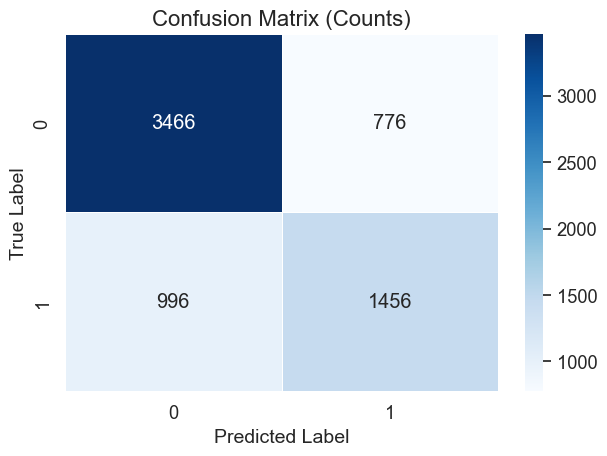

In [ ]:
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="white",
    cbar=True
)

plt.title("Confusion Matrix (Counts)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()